In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import torch
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(precision=2, suppress=False)

In [2]:
from data_processing import *
from yearly_pbnn import *
from torch.utils.data import ConcatDataset

housing_method='constant'
county = 'Illinois_Cook'
dataset = YearlyDataset(county, housing_method=housing_method)

(12, 3, 229, 200)
Building dataset with constant housing in time


(12, 3, 139, 134)
Building dataset with constant housing in time
(12, 3, 229, 200)
Building dataset with constant housing in time
22


Text(0, 0.5, 'Hispanic')

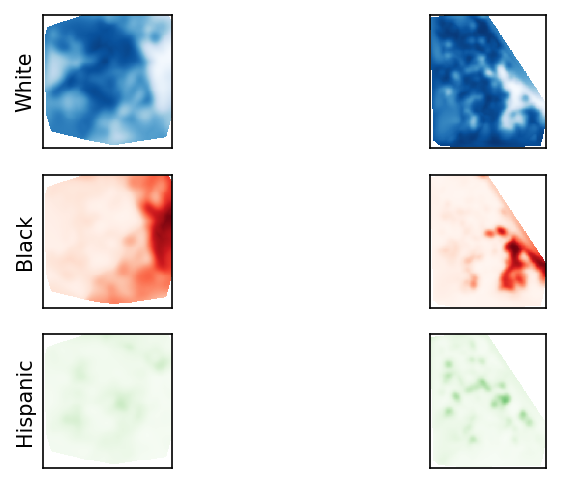

In [3]:
def plot(ax, sample, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)
    ax[2].pcolormesh(sample['x'], sample['y'], sample['wb0'][2], cmap='Greens', vmax=1, vmin=0)
    
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    

housing_method='constant'
dataset = ConcatDataset([
    YearlyDataset('Virginia_Fairfax', housing_method=housing_method),
    YearlyDataset('Illinois_Cook', housing_method=housing_method),
])
print(len(dataset))
fig, ax = plt.subplots(3, len(dataset.datasets), dpi=150)
for i, ds in enumerate(dataset.datasets):
    ds.validate()
    plot(ax[:, i], dataset[i*11])
    
ax[0,0].set_ylabel(f'White')
ax[1,0].set_ylabel(f'Black')
ax[2,0].set_ylabel('Hispanic')

(12, 3, 229, 200)
Building dataset with constant housing in time


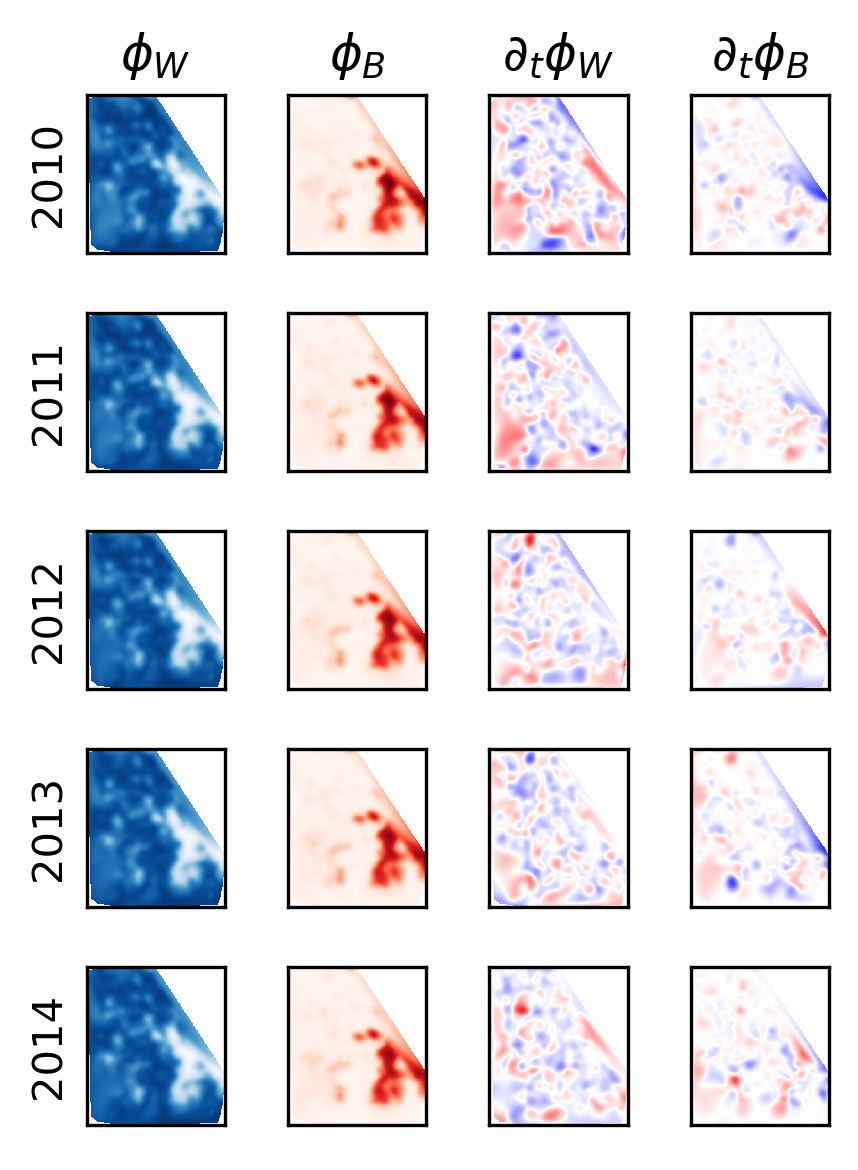

In [4]:
fig, ax = plt.subplots(5, 4, figsize=(3, 4), dpi=300)

county = 'Illinois_Cook'
dataset = YearlyDataset(county, housing_method='constant')
dataset.validate()

vmax = 0.1
for i in range(5):
    wb0 = dataset.wb(2010+i)
    wb1 = dataset.wb(2011+i)
    ax[i, 0].pcolormesh(dataset.x, dataset.y, wb0[0], vmin=0, vmax=1, cmap='Blues')
    ax[i, 1].pcolormesh(dataset.x, dataset.y, wb0[1], vmin=0, vmax=1, cmap='Reds')
    ax[i, 2].pcolormesh(dataset.x, dataset.y, wb1[0]-wb0[0], vmin=-vmax, vmax=vmax, cmap='bwr')
    ax[i, 3].pcolormesh(dataset.x, dataset.y, wb1[1]-wb0[1], vmin=-vmax, vmax=vmax, cmap='bwr')
    ax[i,0].set_ylabel(2010+i)

for a in ax.flatten():
    a.set(xticks=[], yticks=[], aspect='equal')
    
ax[0,0].set_title('$\phi_W$')
ax[0,1].set_title('$\phi_B$')
ax[0,2].set_title('$\partial_t \phi_W$')
ax[0,3].set_title('$\partial_t \phi_B$')
    
plt.tight_layout()

In [5]:
from data_processing import *
county = 'Illinois_Cook'
dataset = YearlyDataset(county, housing_method='constant')
dataset.validate()

mesh = dataset.mesh

area = d_ad.assemble(1*ufl.dx(mesh))
print(area, dataset.mesh_area)

(12, 3, 229, 200)
Building dataset with constant housing in time
2960.6249999999945 2960.6249999999945


Test datasets were:  ['Texas_Bexar', 'Florida_Hillsborough', 'New York_Suffolk', 'California_Santa Clara', 'Pennsylvania_Philadelphia', 'Michigan_Wayne', 'California_Orange', 'California_Los Angeles', 'Nevada_Clark', 'Arizona_Maricopa', 'California_Riverside', 'Texas_Dallas', 'Michigan_Oakland', 'New York_Nassau', 'California_San Bernardino', 'Pennsylvania_Allegheny', 'California_San Diego']
Testing on Pennsylvania_Philadelphia
(12, 3, 100, 74)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

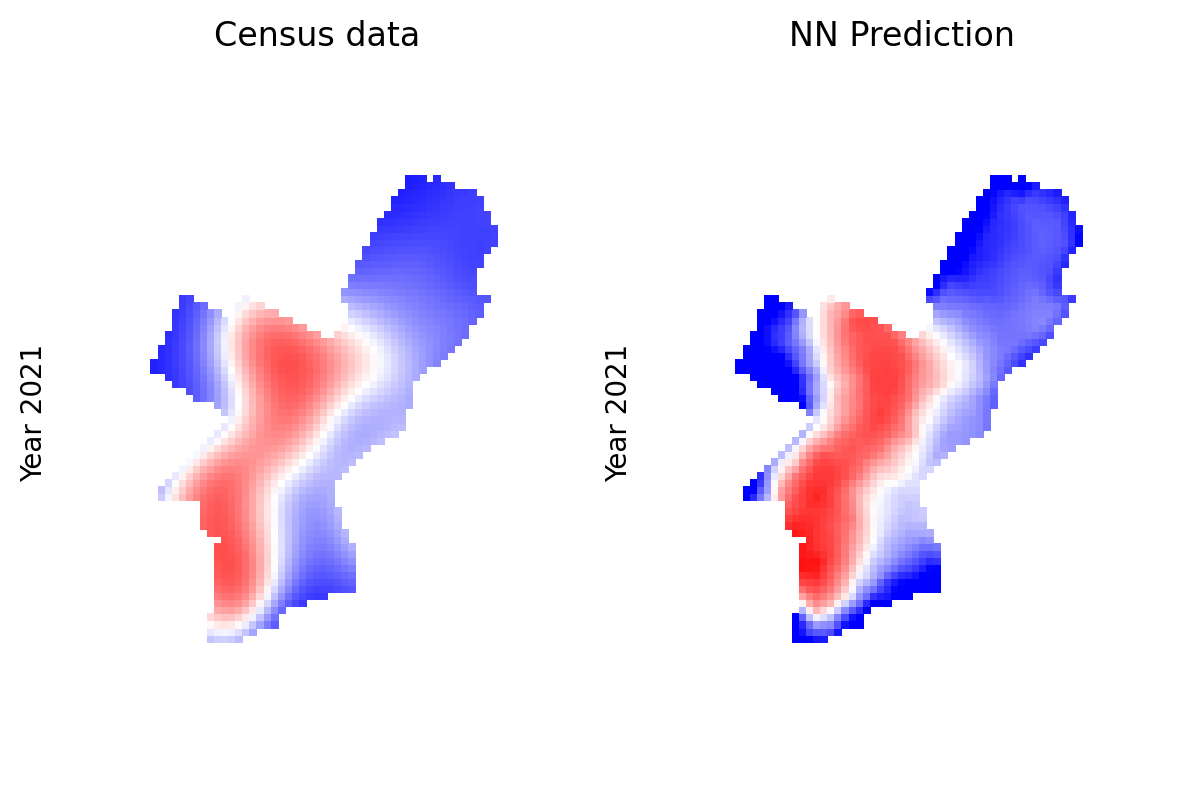

In [24]:
def plot(ax, sample):
    w = sample['wb0'][0] * dataset.housing
    b = sample['wb0'][1] * dataset.housing
    h = sample['wb0'][2] * dataset.housing
    toplot = (w - b) / (w + b + h)
    toplot[~sample['mask']] = np.nan
    ax.pcolormesh(sample['x'], sample['y'], toplot, vmin=-1, vmax=1, cmap='bwr_r')
    ax.set(
        xticks=[],
        yticks=[],
        aspect='equal',
        ylabel=f'Year {sample["t"]:g}'
    ) 

from data_processing import *
from yearly_pbnn import *
from dolfin_problems import *
import json

plt.rcParams['axes.linewidth'] = 0

pipeline=9377999
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'yearly/pipeline_{pipeline}/{model.__class__.__name__}_1.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

with open(f'yearly/pipeline_{pipeline}/{model.__class__.__name__}_1_args.txt', 'r') as f:
    args = json.load(f)
print('Test datasets were: ', args['val_county'])
county = 'Michigan_Wayne'
county = 'Pennsylvania_Philadelphia'
print(f'Testing on {county}')
dataset = YearlyDataset(county, housing_method='constant')
dataset.validate()

t0 = 2010
t1 = 2021
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(1, 2, dpi=200)

plot(ax[0], dataset[tmax])

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, h0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax
    
plot(ax[1], sample)
ax[0].set_title('Census data')
ax[1].set_title('NN Prediction')

plt.tight_layout()

Test datasets were:  ['Texas_Bexar', 'Florida_Hillsborough', 'New York_Suffolk', 'California_Santa Clara', 'Pennsylvania_Philadelphia', 'Michigan_Wayne', 'California_Orange', 'California_Los Angeles', 'Nevada_Clark', 'Arizona_Maricopa', 'California_Riverside', 'Texas_Dallas', 'Michigan_Oakland', 'New York_Nassau', 'California_San Bernardino', 'Pennsylvania_Allegheny', 'California_San Diego']
Testing on Pennsylvania_Philadelphia
(12, 3, 100, 74)
Building dataset with constant housing in time
Si vmax = 0.016229
Si vmax = 0.0177224


  0%|          | 0/11 [00:00<?, ?it/s]

Si vmax = 0.0379812
Target change after 11 years is: 0.00422866
Predicted change after 11 years is: 0.0107282
MSE after 11 years is: 0.00879762


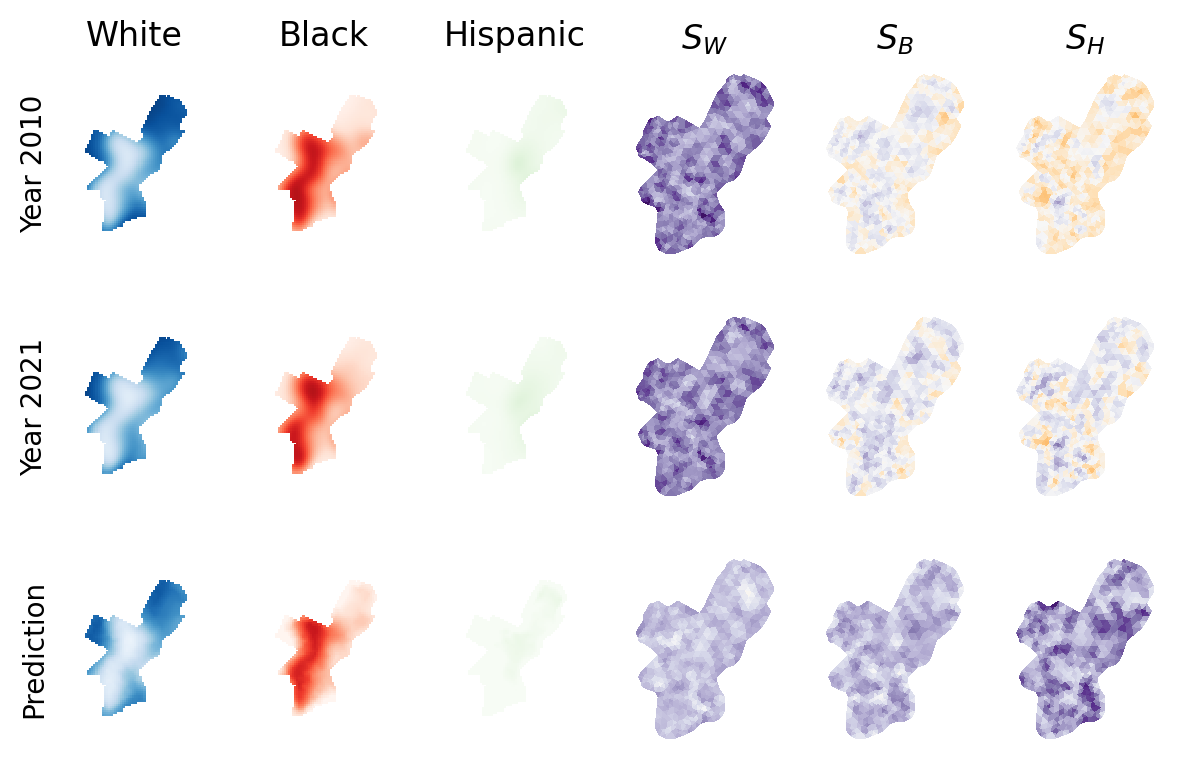

In [23]:
def plot(ax, sample, model, vmax=None):
    wbh = sample['wb0'].clone().detach().numpy()
    wbh[:, ~sample['mask']] = np.nan
    
    ax[0].pcolormesh(sample['x'], sample['y'], wbh[0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], wbh[1], cmap='Reds', vmax=1, vmin=0)
    ax[2].pcolormesh(sample['x'], sample['y'], wbh[2], cmap='Greens', vmax=1, vmin=0)

    with torch.no_grad(), d_ad.stop_annotating():
        sample['wb0'] = sample['wb0'].to(device)
        params = model.forward(sample['wb0'][None],
                               sample['problem'].FctSpace,
                               (sample['x'], sample['y']))
        Si  = params['Si'].detach().cpu().numpy()
    
    vmax = np.max(np.abs(Si))
    print(f'Si vmax = {vmax:g}')
    for i in range(3):
        plot_mesh(ax[3+i], Si[i], dataset.mesh, cmap='PuOr', vmin=-vmax, vmax=vmax)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_ylabel(f'Year {sample["t"]:g}')
    
    return sample['wb0'].detach().cpu().numpy(), Si

from data_processing import *
from yearly_pbnn import *
from dolfin_problems import *
import json

pipeline=9377999
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'yearly/pipeline_{pipeline}/{model.__class__.__name__}_1.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

with open(f'yearly/pipeline_{pipeline}/{model.__class__.__name__}_1_args.txt', 'r') as f:
    args = json.load(f)
print('Test datasets were: ', args['val_county'])
county = 'Michigan_Wayne'
county = 'Pennsylvania_Philadelphia'
print(f'Testing on {county}')
dataset = YearlyDataset(county, housing_method='constant')
dataset.validate()

t0 = 2010
t1 = 2021
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(3, 6, dpi=200)

wb0, Si0 = plot(ax[0], sample, model)
wb1, Si1 = plot(ax[1], dataset[tmax], model)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, h0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

wb2, Si2 = plot(ax[2], sample, model)
ax[2,0].set_ylabel('Prediction')

print(f'Target change after {tmax} years is: {np.mean((wb1[:, mask]-wb0[:, mask])**2):g}')
print(f'Predicted change after {tmax} years is: {np.mean((wb2[:, mask]-wb0[:, mask])**2):g}')
print(f'MSE after {tmax} years is: {np.mean((wb2[:, mask]-wb1[:, mask])**2):g}')

ax[0,0].set_title('White')
ax[0,1].set_title('Black')
ax[0,2].set_title('Hispanic')
ax[0,3].set_title('$S_{W}$')
ax[0,4].set_title('$S_{B}$')
ax[0,5].set_title('$S_{H}$')

plt.tight_layout()

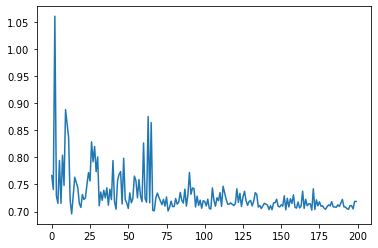

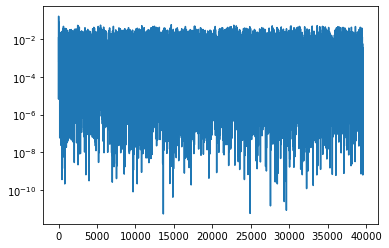

In [8]:
plt.figure()
plt.plot(info['val_loss'])
plt.figure()
plt.semilogy(info['train_loss'])

# Build a spatial saliency map

In [7]:
def forward(model, wb0, FctSpace, xy):
    #Neural network part
    x = model.read_in(wb0)
    for cell in model.cnn1:
        x = x + cell(x)
    latent = model.downsample(x)
    for cell in model.cnn2:
        latent = latent + cell(latent)
    latent = F.interpolate(latent, x.shape[-2:])
    x = torch.cat([x, latent], dim=1)
    S = model.read_out(x).squeeze()
    return {
        'Si': S,
    }

def aggregate_sample(model, sample):
    sample['wb0'] = sample['wb0'].to(device)[None]
    sample['wb0'][sample['wb0'].isnan()] = 0
    sample['wb0'].requires_grad = True
    params = forward(
        model,
        sample['wb0'],
        sample['problem'].FctSpace,
        (sample['x'], sample['y']))

    nnz = np.asarray(np.nonzero(sample['mask'])).T
    np.random.shuffle(nnz)
    pts = nnz[:100]

    G_S = []
    for pt in pts:
        loc = torch.zeros_like(params['Si'][0])
        loc[pt[0], pt[1]] = 1.

        grad = []
        for j in range(params['Si'].shape[0]):
            grad.append(torch.autograd.grad(params['Si'][j], sample['wb0'], grad_outputs=loc, retain_graph=True)[0])
        grad = torch.stack(grad) #[3, 3, Y, X]
        G_S.append(grad.detach().cpu().numpy().squeeze())
    
    center = np.asarray([G_S[0].shape[-2]/2, G_S[0].shape[-1]/2]).astype(int)
    shifts = np.asarray(center-pts)

    G_S_shifted = np.asarray([np.roll(g, shift, axis=(-2,-1)) for shift, g in zip(shifts, G_S)])

    return G_S_shifted

import h5py
from tqdm.auto import tqdm

pipelines = [9281516, 9281518, 9281524, 9281526, 9281527]
modeltype = SourcedOnlyPBNN
model = modeltype().to(device)

for pipeline in pipelines:
    print(f'Processing pipeline {pipeline}')
    info = torch.load(f'yearly/pipeline_{pipeline}/constant/{modeltype.__name__}.ckpt', map_location='cpu')
    model.load_state_dict(info['state_dict'])
    model.train()

    with open(f'yearly/pipeline_{pipeline}/constant/{model.__class__.__name__}_args.txt', 'r') as f:
        args = json.load(f)

    with h5py.File(f'yearly/pipeline_{pipeline}/constant/{modeltype.__name__}_saliency.h5', 'w') as h5f:
        for county in args['val_county']:
            ds = h5f.create_group(county)

            dataset = YearlyDataset(county, housing_method=args['housing_method'])
            dataset.validate()

            ds.create_dataset('X', data=dataset.x) #REMEMBER TO SUBTRACT MEAN TO ALIGN
            ds.create_dataset('Y', data=dataset.y)

            gs = ds.create_group('G_S')
            for i in trange(len(dataset)):
                sample = dataset[i]
                G_S = aggregate_sample(model, sample)
                gs.create_dataset(f'{int(sample["t"])}', data=G_S)

Processing pipeline 9281516
(12, 3, 152, 248)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 216, 203)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 225, 208)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 314, 387)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 151, 166)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 207, 183)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 247, 276)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 194, 199)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 139, 134)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 150, 147)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 171, 166)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 154, 141)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 124, 100)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 746, 1008)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 167, 167)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

Processing pipeline 9281518
(12, 3, 152, 248)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 216, 203)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 225, 208)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 314, 387)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 100, 74)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 151, 166)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 207, 183)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 688, 401)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 305, 236)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 150, 147)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 154, 141)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 133, 150)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 124, 100)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 283, 353)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 229, 200)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 746, 1008)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 375, 412)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

Processing pipeline 9281524
(12, 3, 152, 248)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 225, 208)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 100, 74)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

(12, 3, 207, 183)
Building dataset with constant housing in time


  0%|          | 0/11 [00:00<?, ?it/s]

RuntimeError: *** Error: Duplication of MPI communicator failed (MPI_Comm_dup

In [ ]:
G_s, X_s, Y_s = [], [], []

pipeline = 9281516
with h5py.File(f'yearly/pipeline_{pipeline}/constant/{modeltype.__name__}_saliency.h5', 'r') as h5f:
    for county in h5f.keys():
        print(county)
        gs = h5f[f'{county}/G_S']
        try:
            G_s.append(
                np.sum(np.array([gs[t] for t in gs.keys()]), axis=(0,1)))
            X_s.append(h5f[f'{county}/X'] - np.mean(h5f[f'{county}/X']))
            Y_s.append(h5f[f'{county}/Y'] - np.mean(h5f[f'{county}/Y']))
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape)

California_Alameda
(3, 3, 194, 199) (194, 199) (194, 199)
California_Orange
(3, 3, 207, 183) (207, 183) (207, 183)
California_San Bernardino


61.749999999999545 56.0


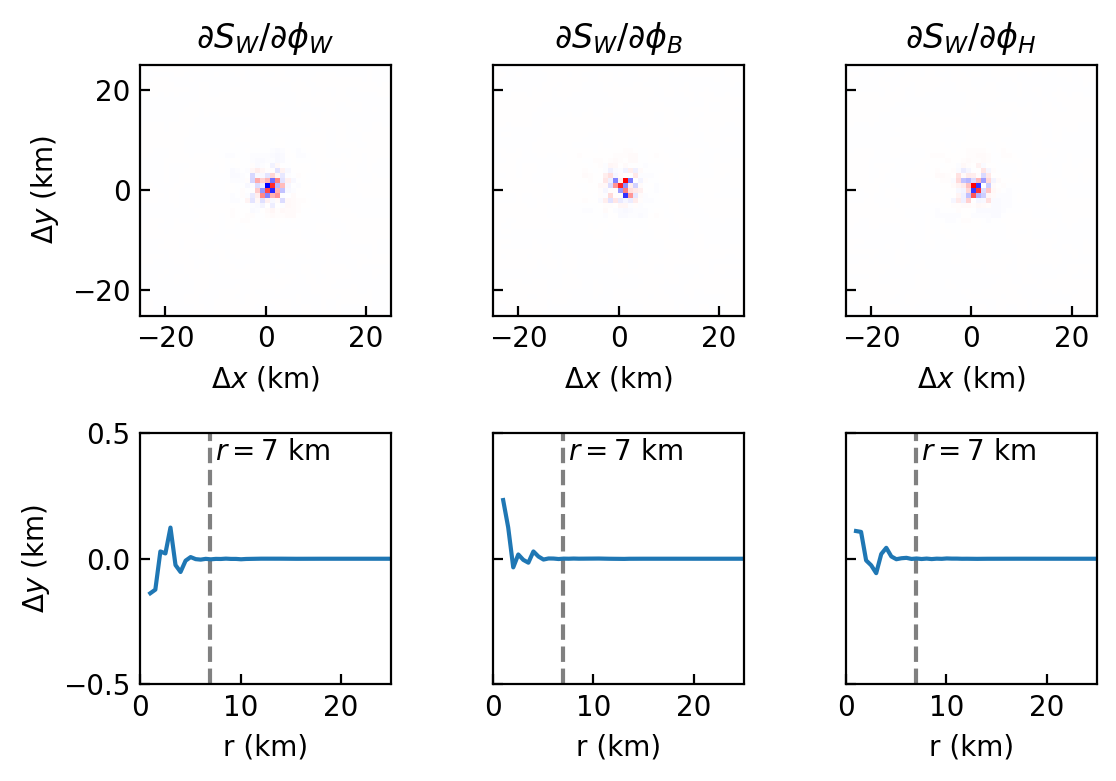

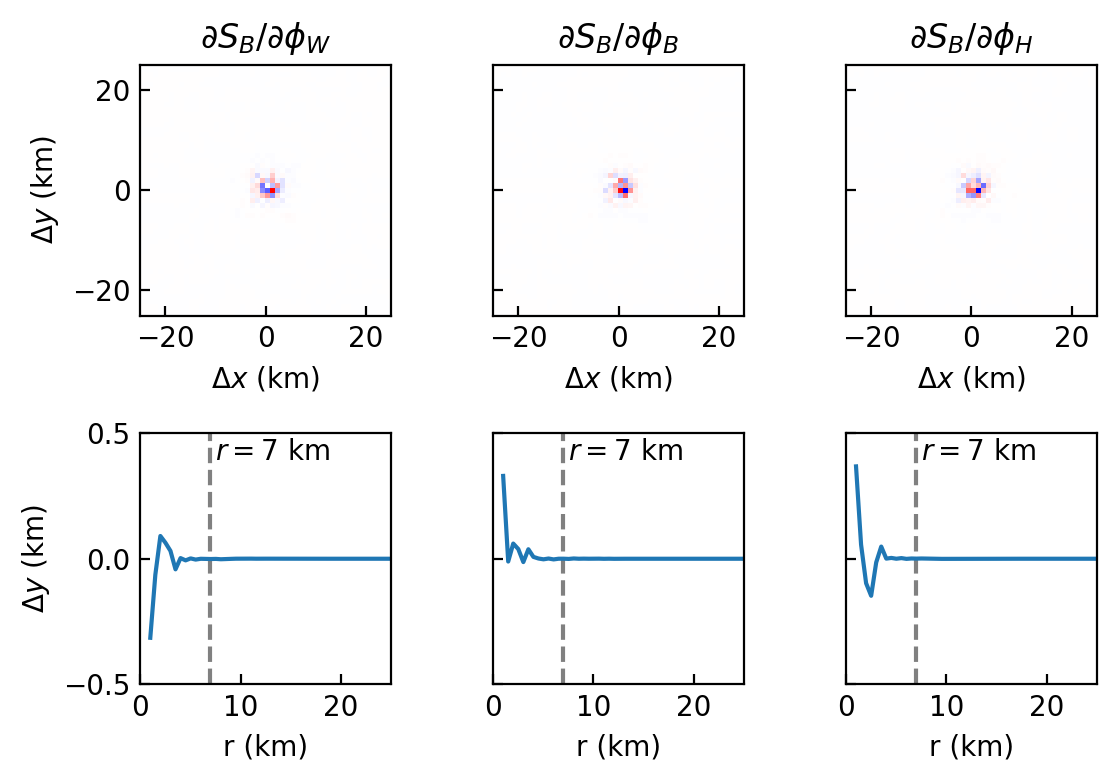

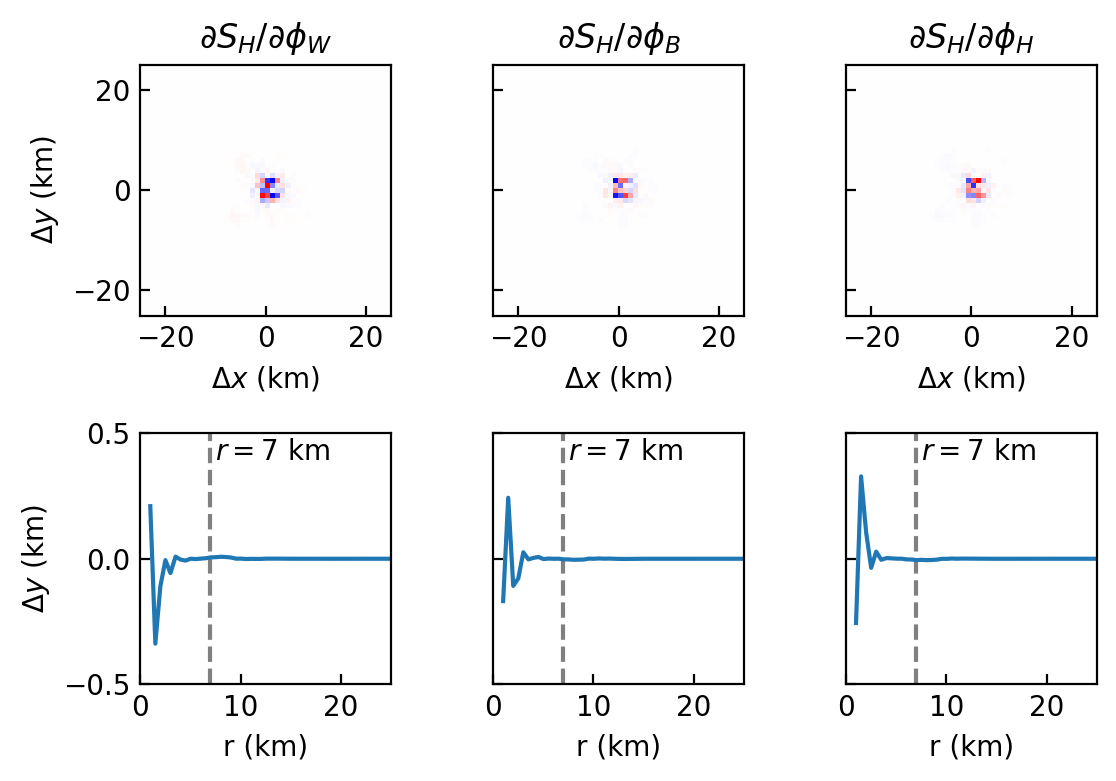

In [9]:
from scipy.interpolate import RectBivariateSpline

xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(xmax, ymax)

x = np.linspace(-xmax, xmax, int(2*xmax))
y = np.linspace(-ymax, ymax, int(2*ymax))
x, y = np.meshgrid(x, y, indexing='xy')

rgrid = np.linalg.norm(np.stack([x, y]), axis=0)
r = np.linspace(0, 100, 200)

labels = ['W', 'B', 'H']

for ii in range(3):
    fig, ax = plt.subplots(2, 3, figsize=(6, 4), dpi=200,
                           sharey='row', sharex='row')
    for jj in range(3):
        Gr = np.zeros(rgrid.shape)
        for kk in range(len(G_s)):
            Gsj = G_s[kk][ii, jj]
            xj = X_s[kk]
            yj = Y_s[kk]
            Gr += RectBivariateSpline(yj[:,0], xj[0,:], Gsj)(y[:, 0], x[0, :])

        Gr = Gr / (4*40)
        Gr = Gr / np.abs(Gr).max()
        ax[0, jj].pcolormesh(x, y, Gr,
                            vmin=-1, vmax=1, cmap='bwr')

        ax[0, jj].set(
            xlabel=r'$\Delta x$ (km)',
            aspect='equal',
        )

        gr = np.zeros(len(r)-1)
        for j in range(len(r)-1):
            gr[j] = np.mean(Gr[(rgrid>=r[j])*(rgrid<r[j+1])])
        ax[1, jj].plot(r[1:], gr)
        ax[1, jj].set(xlabel='r (km)')
        
        ax[0,jj].set(
            xlim=[-25, 25],
            ylim=[-25, 25])
        ax[1,jj].set(
            xlim=[0, 25],
            ylim=[-0.5, 0.5],
            xticks=[0, 10, 20],
            yticks=[-0.5, 0, 0.5])
        ax[1,jj].set_aspect(np.ptp(ax[1,jj].get_xlim()) / np.ptp(ax[1,jj].get_ylim()))

        r0 = 7
        ax[1,jj].axvline(r0, linestyle='--', zorder=-1, color='grey')
        ax[1,jj].text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
                     transform=ax[1,jj].transData)

        ax[0,jj].tick_params(which='both', direction='in')
        ax[1,jj].tick_params(which='both', direction='in')
    
        ax[0,jj].set_title(f'$\\partial S_{labels[ii]} / \\partial \\phi_{labels[jj]}$')
    ax[0,0].set_ylabel(r'$\Delta y$ (km)')
    ax[1,0].set_ylabel(r'$\Delta y$ (km)')

    plt.tight_layout()